In [1]:
!nvidia-smi -q


==============NVSMI LOG==============

Timestamp                                 : Wed Aug 31 22:53:41 2022
Driver Version                            : 510.54
CUDA Version                              : 11.6

Attached GPUs                             : 1
GPU 00000000:8A:00.0
    Product Name                          : NVIDIA GeForce GTX 1080 Ti
    Product Brand                         : GeForce
    Product Architecture                  : Pascal
    Display Mode                          : Disabled
    Display Active                        : Disabled
    Persistence Mode                      : Disabled
    MIG Mode
        Current                           : N/A
        Pending                           : N/A
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : N/A
        Pending                           : N/A
    Serial Number                         : 0320817043387
    GPU 

In [2]:
import os.path as osp

import torch
import torch.nn.functional as F
from ogb.nodeproppred import PygNodePropPredDataset

import torch_geometric.transforms as T
from torch_geometric.nn import MaskLabel, TransformerConv
from torch_geometric.utils import index_to_mask

import sys
sys.path.insert(0, '..')  #go up one directory
from custom_libraries.my_functions import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [4]:
!pwd

/ssl-jet-vol/semi-supervised-tests/Jupyter


In [5]:
root = "/ssl-jet-vol/semi-supervised-tests/Jupyter/data/OGB"
dataset = PygNodePropPredDataset('ogbn-arxiv', root, T.ToUndirected())
dataset

PygNodePropPredDataset()

In [6]:
class UniMP(torch.nn.Module):   #UniMP stands for Unified Message Passing
    def __init__(self, in_channels, num_classes, hidden_channels, num_layers,
                 heads, dropout=0.3):
        super().__init__()

        self.label_emb = MaskLabel(num_classes, in_channels)

        self.convs = torch.nn.ModuleList()  # initialize self.convs
        self.norms = torch.nn.ModuleList()  # initialize self.norms
        for i in range(1, num_layers + 1):
            if i < num_layers:
                out_channels = hidden_channels // heads #what is a head?
                concat = True   #what does concat do?
            else:
                out_channels = num_classes
                concat = False
            conv = TransformerConv(in_channels, out_channels, heads,
                                   concat=concat, beta=True, dropout=dropout)
            self.convs.append(conv)
            in_channels = hidden_channels

            if i < num_layers:
                self.norms.append(torch.nn.LayerNorm(hidden_channels))
                
    def forward(self, x, y, edge_index, label_mask):
        x = self.label_emb(x, y, label_mask)  #mask some of the input labels
        for conv, norm in zip(self.convs, self.norms):
            x = norm(conv(x, edge_index)).relu()
        # conv -> norm -> ReLu -> conv -> norm -> Relu -> ... -> out
        return self.convs[-1](x, edge_index)

## Questions:  

### 2. What does emb stand for?  
Embedding

### 3. What are normalization layers?  what do they do and why do we need them?
https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html  
Normalization? but why?

### 3.1 What are heads?  

### 4. What does concat do?  
If set to False, the multi-head attentions are averaged instead of concatenated. (default: True)  

### 4.1 What are attentions?  

### 7. Why a separate if statement for self.norms?


### 8. What does each parameter mean in this function?  
x: input?  
y: output?  
edge_index: how the graph is connected  
label_mask: 

### 8.1 What does the first line do?  

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)
data.y = data.y.view(-1)
model = UniMP(dataset.num_features, dataset.num_classes, hidden_channels=64,
              num_layers=3, heads=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
 
split_idx = dataset.get_idx_split()   # train/val/test split
train_mask = index_to_mask(split_idx['train'], size=data.num_nodes)
val_mask = index_to_mask(split_idx['valid'], size=data.num_nodes)
test_mask = index_to_mask(split_idx['test'], size=data.num_nodes)

In [9]:
def train(label_rate=0.65):  # How many labels to use for propagation.
    model.train()

    propagation_mask = MaskLabel.ratio_mask(train_mask, ratio=label_rate)
    # Randomly modifies mask by setting a certain ratio (label_rate) of True entries to False
    supervision_mask = train_mask ^ propagation_mask  # Exclusive or: Sets each bit to 1 if only one of two bits is 1
#     print("train_mask:", train_mask)
#     print("propagation_mask:", propagation_mask)
#     print("supervision_mask:", supervision_mask)

    optimizer.zero_grad()
    out = model(data.x, data.y, data.edge_index, propagation_mask)  #forward is called
    loss = F.cross_entropy(out[supervision_mask], data.y[supervision_mask])
    loss.backward()
    optimizer.step()

    return float(loss)


@torch.no_grad()
def test():
    model.eval()

    # evaluation
    propagation_mask = train_mask  #no masked nodes while testing
    out = model(data.x, data.y, data.edge_index, propagation_mask)  # forward is called
    pred = out[val_mask].argmax(dim=-1)  #indices of maximum values across the last dimension
    val_acc = int((pred == data.y[val_mask]).sum()) / pred.size(0)  # Validation accuracy
#     print("out:", out)
#     print("out dim:", out.size())
#     print("out[val_mask] dim:", out[val_mask].size())
#     print("out[test_mask] size:", out[test_mask].size())
#     print("out[train_mask] size:", out[train_mask].size())
#     print("out summed over dimension 1", torch.sum(out, dim=1))
# #     print("out[val_mask]:", out[val_mask])
#     print("eval pred:", pred)
#     print("labels:", data.y[val_mask])
#     print("pred size:",pred.size())
#     print("data.y[val_mask] size:", data.y[val_mask].size())

    # testing
    propagation_mask = train_mask | val_mask    #Or: Sets each bit to 1 if one of two bits is 1
    out = model(data.x, data.y, data.edge_index, propagation_mask)
    pred = out[test_mask].argmax(dim=-1)
    test_acc = int((pred == data.y[test_mask]).sum()) / pred.size(0)
#     print("test pred", pred)
    
#     print("labels:", data.y[test_mask])

    return val_acc, test_acc

# Summary
out is a torch tensor of dimension [169343, 40].  
out[val_mask] is a torch tensor of dimension [29799, 40].  
This ratio 0.1759683 should be one of the three numbers in the train/val/test split.  
This is confirmed by   
out[val_mask] dim: torch.Size([29799, 40])  
out[test_mask] size: torch.Size([48603, 40])  
out[train_mask] size: torch.Size([90941, 40])  
(The three numbers add up to out.size(0))  

(during evaluation) pred is a torch tensor of dimension [29799]  
It is the indices of maximum values across the second dimension of out[val_mask]

I am assuming each of the 40 numbers is some sort of probability of classifying a data point into a certain category. **But they are negative and do not sum to 1. How to interpret these?**   

Apply softmax to the results to obtain probabilities.
This way, pred then consists of the predictions of the model (which category does a certain data point fall into)

### 13. What is propagation_mask?  
decides which nodes to use for message passing
### 13.1 What is supervision_mask?  
decides which nodes to use for verifying predictions  
(propagation + supervision = training)

## 14. What is argmax(dim=-1)
Returns the indices of the maximum values of a tensor across a dimension.
https://pytorch.org/docs/stable/generated/torch.argmax.html

finding the argument that gives the max value across the last dimension, which is 40.  
But now what does the 40 represent?  
40 categories

In [10]:
def reset_params(model):
    for layer in model.children():
       if hasattr(layer, 'reset_parameters'):
           layer.reset_parameters()

In [11]:
reset_params(model)

label_rate = 0.65
num_epochs = 100
loss_lst, val_acc_lst, test_acc_lst = [], [], []

for epoch in range(1, num_epochs+1):
    loss = train(label_rate = label_rate)
    val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')
    loss_lst.append(loss)
    val_acc_lst.append(val_acc)
    test_acc_lst.append(test_acc)

Epoch: 001, Loss: 3.7189, Val: 0.1794, Test: 0.1826
Epoch: 002, Loss: 3.5910, Val: 0.2448, Test: 0.2366
Epoch: 003, Loss: 3.4800, Val: 0.3046, Test: 0.2771
Epoch: 004, Loss: 3.3936, Val: 0.3145, Test: 0.2863
Epoch: 005, Loss: 3.3190, Val: 0.3171, Test: 0.2893
Epoch: 006, Loss: 3.2540, Val: 0.3245, Test: 0.3005
Epoch: 007, Loss: 3.1995, Val: 0.3459, Test: 0.3366
Epoch: 008, Loss: 3.1346, Val: 0.3737, Test: 0.3680
Epoch: 009, Loss: 3.0797, Val: 0.4014, Test: 0.3989
Epoch: 010, Loss: 3.0188, Val: 0.4296, Test: 0.4319
Epoch: 011, Loss: 2.9689, Val: 0.4568, Test: 0.4627
Epoch: 012, Loss: 2.9075, Val: 0.4840, Test: 0.4904
Epoch: 013, Loss: 2.8529, Val: 0.5049, Test: 0.5133
Epoch: 014, Loss: 2.8017, Val: 0.5206, Test: 0.5311
Epoch: 015, Loss: 2.7521, Val: 0.5330, Test: 0.5450
Epoch: 016, Loss: 2.7004, Val: 0.5438, Test: 0.5559
Epoch: 017, Loss: 2.6496, Val: 0.5526, Test: 0.5674
Epoch: 018, Loss: 2.5978, Val: 0.5605, Test: 0.5758
Epoch: 019, Loss: 2.5516, Val: 0.5716, Test: 0.5841
Epoch: 020, 

In [12]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

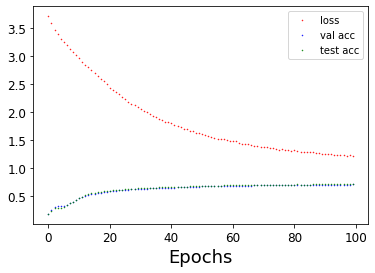

In [13]:
marker_size = 1
plt.plot(loss_lst, "r.", markersize=marker_size, label="loss")
plt.plot(val_acc_lst, "b.", markersize=marker_size, label="val acc")
plt.plot(test_acc_lst, "g.",markersize=marker_size, label="test acc")
plt.xlabel("Epochs", fontsize=18)
# plt.ylabel("value of params", rotation=90, fontsize=18)
plt.legend(loc="best", fontsize=10)
# plt.xlim([200, 500])
plt.show()

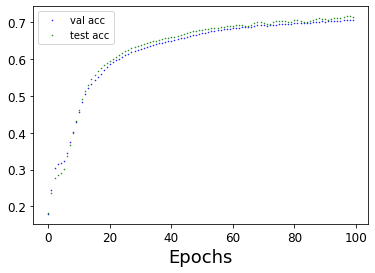

In [14]:
marker_size = 1
plt.plot(val_acc_lst, "b.", markersize=marker_size, label="val acc")
plt.plot(test_acc_lst, "g.",markersize=marker_size, label="test acc")
plt.xlabel("Epochs", fontsize=18)
# plt.ylabel("value of params", rotation=90, fontsize=18)
plt.legend(loc="best", fontsize=10)
# plt.xlim([200, 500])
plt.show()

In [15]:
print("best val epoch:", torch.Tensor(val_acc_lst).argmax())
print("best test epoch:", torch.Tensor(test_acc_lst).argmax())
print("best val acc:", torch.Tensor(val_acc_lst).max())
print("best test acc:", torch.Tensor(test_acc_lst).max())

best val epoch: tensor(99)
best test epoch: tensor(97)
best val acc: tensor(0.7063)
best test acc: tensor(0.7166)


# Optimize label_rate

In [16]:
import numpy as np
label_rate_arr = np.linspace(0.0, 1.0, num=21)

In [17]:
def optimization_loop(label_rate):
    reset_params(model)
    num_epochs = 300
    loss_lst, val_acc_lst, test_acc_lst = [], [], []

    print(f'Label_rate: {label_rate}')
    for epoch in range(1, num_epochs+1):
        loss = train(label_rate = label_rate)
        val_acc, test_acc = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, '
              f'Test: {test_acc:.4f}')
        loss_lst.append(loss)
        val_acc_lst.append(val_acc)
        test_acc_lst.append(test_acc)
    return loss_lst, val_acc_lst, test_acc_lst

In [18]:
# best_val_acc_lst, best_val_epoch_lst, best_test_acc_lst, best_test_epoch_lst = [], [], [], []
# for lr in label_rate_arr:
#     print(lr)
#     lost_lst, val_acc_lst, test_acc_lst = optimization_loop(lr)
    
#     best_val_epoch_lst.append(torch.Tensor(val_acc_lst).argmax())
#     best_val_acc_lst.append(torch.Tensor(val_acc_lst).max())
#     best_test_epoch_lst.append(torch.Tensor(test_acc_lst).argmax())
#     best_test_acc_lst.append(torch.Tensor(test_acc_lst).max())

In [19]:


# marker_size = 3
# fig, axs = plt.subplots(2, 2)
# axs[0, 0].plot(best_val_epoch_lst, "b.", markersize=marker_size)
# axs[0, 0].set_title("best val epoch")


# axs[0, 1].plot(best_val_acc_lst, "b.",markersize=marker_size)
# axs[0, 1].set_title("best val acc")

# axs[1, 0].plot(best_test_epoch_lst, "b.",markersize=marker_size)
# axs[1, 0].set_title("best test epoch")

# axs[1, 1].plot(best_test_acc_lst, "b.",markersize=marker_size)
# axs[1, 1].set_title("best test acc")

# plt.show()

### Obtain predicted probabilities

In [21]:
propagation_mask = train_mask | val_mask    #Or: Sets each bit to 1 if one of two bits is 1
out = model(data.x, data.y, data.edge_index, propagation_mask)
pred = out[test_mask].argmax(dim=-1)
test_acc = int((pred == data.y[test_mask]).sum()) / pred.size(0)

In [28]:
m = torch.nn.Softmax(dim=1)
out_norm = m(out)  # the predicted probabilities

### Plot number of data points for each label

In [40]:
classes = np.array([i for i in range(40)])
labels_arr = data.y[train_mask].cpu().numpy()
class_dict = plot_class_balance(classes, labels_arr)

### Plot accuracy of predictions for each class

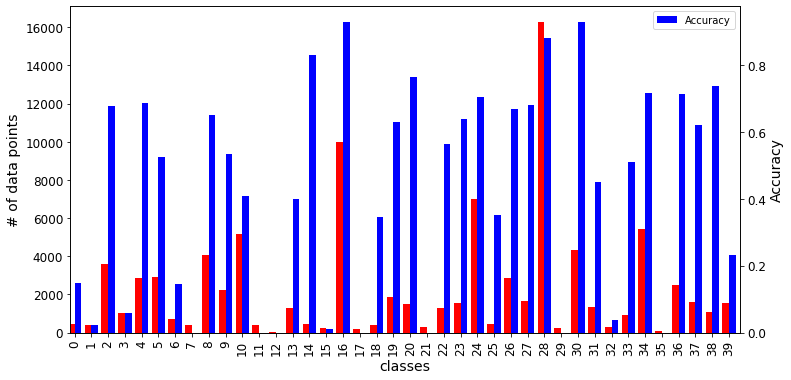

In [105]:
"""
fig = plt.figure(figsize=(12, 6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

df['# of data points'].plot(kind='bar', color='red', ax=ax, width=width, position=1, label='# of data points')
df["Accuracy"].plot(kind='bar', color='blue', ax=ax2, width=width, position=0, label="Accuracy")

ax.set_xlabel('classes')
ax.set_ylabel('# of data points')
ax2.set_ylabel("Accuracy")
plt.legend()
plt.show()
"""

In [ ]:
labels_arr = data.y[test_mask].cpu().numpy()
plot_class_balance_and_accuracy(class_dict, classes, labels_arr, pred)

### Calculate and plot AUC for each class

0.8971836777352855
0.6587894884265068
0.9860811639983346
0.866264506445846
0.9570673801705464
0.9412474374573164
0.8024328828982479
0.8603382589825841
0.9693449876459781
0.9821477673447252
0.8828295457427763
0.8181568710638882
0.7339931684431458
0.9171035538015753
0.9737788803205784
0.9319004134671061
0.9751808054945045
0.6866548263648578
0.9501808619163316
0.9327966938192777
0.9702733815995876
0.8027015304391653
0.9711490507991667
0.954440167837267
0.9271970245466468
0.9701824520576708
0.9615421739220531
0.9635606750863968
0.9914196202061744
0.8421668419858508
0.9855794159503515
0.9348535131128158
0.9796655707744415
0.9775668764197792
0.9772888510594626
0.8431542451092763
0.971169163795082
0.9574437925919578
0.9641513103599857
0.9452580041326439


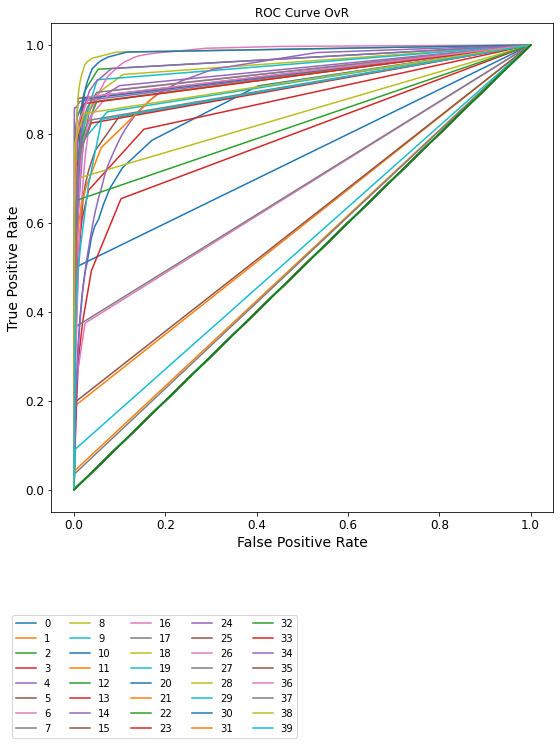

In [29]:
classes = np.array([i for i in range(40)])
roc_auc_ovr = plot_overlayed_roc_curve(classes, data.y[test_mask], out_norm[test_mask][:, classes], ncol=5)

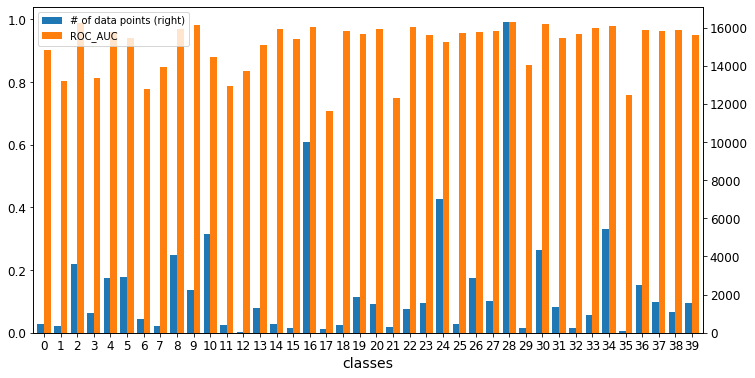

In [123]:
plot_class_balance_and_AUC(class_dict, roc_auc_ovr)